In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'ETH'

# Create crypto df
crypto_df = f'{crypto}_df'.lower()

In [5]:
# Store the crypto data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
crypto_df = pd.read_csv(
    f'~/crypto-forecast/Resources/{crypto}-USD.csv',
    index_col='Date',
    parse_dates=True
).dropna()

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-16,532.073975,534.197021,500.250000,511.147003,511.147003,1758979968
2018-04-17,511.144989,518.031006,502.563995,502.894012,502.894012,1760359936
2018-04-18,503.308990,525.091980,503.045013,524.789001,524.789001,1762940032
2018-04-19,524.038025,567.888977,523.262024,567.888977,567.888977,2256869888
2018-04-20,567.989014,618.715027,560.283020,615.718018,615.718018,2849469952


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-13,2928.81,2994.87,2865.13,2949.36,2949.36,13352264795
2024-05-14,2949.21,2959.55,2863.55,2881.16,2881.16,12444516140
2024-05-15,2881.22,3041.60,2864.74,3037.06,3037.06,14666902956
2024-05-16,3036.01,3041.81,2925.09,2945.13,2945.13,13035465176
2024-05-17,2945.14,3120.30,2934.11,3094.12,3094.12,14449438097


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

3094.12

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999191,0.998343,0.997853,0.997853,0.453805
High,0.999191,1.000000,0.998073,0.998912,0.998912,0.467004
Low,0.998343,0.998073,1.000000,0.998918,0.998918,0.431021
Close,0.997853,0.998912,0.998918,1.000000,1.000000,0.451149
Adj Close,0.997853,0.998912,0.998918,1.000000,1.000000,0.451149
Volume,0.453805,0.467004,0.431021,0.451149,0.451149,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2018-04-16,511.147003,1758979968
2018-04-17,502.894012,1760359936
2018-04-18,524.789001,1762940032
2018-04-19,567.888977,2256869888
2018-04-20,615.718018,2849469952
...,...,...
2024-05-13,2949.360000,13352264795
2024-05-14,2881.160000,12444516140
2024-05-15,3037.060000,14666902956


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2018-06-04,592.984985,1903430016,576.177209,656.125901,653.879281
2018-06-05,609.302979,1844269952,578.379504,650.025635,655.842401
2018-06-06,607.124023,1756530048,581.825104,645.138936,657.927001
2018-06-07,605.187012,1880140032,590.740204,640.216604,659.534961
2018-06-08,601.077026,1637779968,594.309106,635.176670,660.198722


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-05-13,2949.36,13352264795,3003.327,3081.792947,3228.177604
2024-05-14,2881.16,12444516140,2979.685,3072.600217,3213.983128
2024-05-15,3037.06,14666902956,2969.666,3070.448872,3202.974231
2024-05-16,2945.13,13035465176,2957.906,3065.459000,3191.874526
2024-05-17,3094.12,14449438097,2966.660,3069.105333,3182.531047


<Axes: xlabel='Date'>

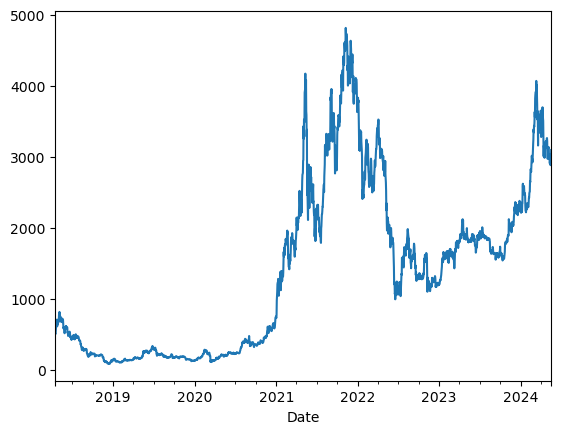

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2018-04-16,511.147003,1758979968
1,2018-04-17,502.894012,1760359936
2,2018-04-18,524.789001,1762940032
3,2018-04-19,567.888977,2256869888
4,2018-04-20,615.718018,2849469952
...,...,...,...
2219,2024-05-13,2949.360000,13352264795
2220,2024-05-14,2881.160000,12444516140
2221,2024-05-15,3037.060000,14666902956
2222,2024-05-16,2945.130000,13035465176


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

18:01:32 - cmdstanpy - INFO - Chain [1] start processing
18:01:32 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
2309,2024-08-11
2310,2024-08-12
2311,2024-08-13
2312,2024-08-14
2313,2024-08-15


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2284,2024-07-17,3155.789230,2598.888519,3322.062072,3102.649912,3197.858243,-188.530563,-188.530563,-188.530563,4.440046,4.440046,4.440046,-192.970609,-192.970609,-192.970609,0.0,0.0,0.0,2967.258667
2285,2024-07-18,3159.268628,2609.383671,3332.378617,3104.755052,3203.514405,-186.276894,-186.276894,-186.276894,0.410163,0.410163,0.410163,-186.687056,-186.687056,-186.687056,0.0,0.0,0.0,2972.991735
2286,2024-07-19,3162.748026,2610.229750,3322.026097,3105.005774,3209.315587,-184.123401,-184.123401,-184.123401,-4.060441,-4.060441,-4.060441,-180.062961,-180.062961,-180.062961,0.0,0.0,0.0,2978.624625
2287,2024-07-20,3166.227425,2620.214554,3353.120522,3105.443043,3214.674877,-175.683466,-175.683466,-175.683466,-2.551814,-2.551814,-2.551814,-173.131651,-173.131651,-173.131651,0.0,0.0,0.0,2990.543959
2288,2024-07-21,3169.706823,2609.644277,3369.238556,3105.331989,3220.636685,-164.240617,-164.240617,-164.240617,1.686339,1.686339,1.686339,-165.926956,-165.926956,-165.926956,0.0,0.0,0.0,3005.466206
2289,2024-07-22,3173.186221,2681.388055,3407.959005,3106.095967,3225.934943,-157.158089,-157.158089,-157.158089,1.325285,1.325285,1.325285,-158.483373,-158.483373,-158.483373,0.0,0.0,0.0,3016.028132
2290,2024-07-23,3176.665619,2631.081938,3427.636974,3107.121598,3230.426543,-152.085860,-152.085860,-152.085860,-1.249577,-1.249577,-1.249577,-150.836283,-150.836283,-150.836283,0.0,0.0,0.0,3024.579759
2291,2024-07-24,3180.145017,2674.056674,3395.584717,3107.535127,3234.846723,-138.582132,-138.582132,-138.582132,4.440046,4.440046,4.440046,-143.022178,-143.022178,-143.022178,0.0,0.0,0.0,3041.562885
2292,2024-07-25,3183.624415,2694.389017,3407.971353,3109.260629,3239.683896,-134.668731,-134.668731,-134.668731,0.410163,0.410163,0.410163,-135.078894,-135.078894,-135.078894,0.0,0.0,0.0,3048.955684
2293,2024-07-26,3187.103813,2687.657374,3429.023606,3111.196391,3245.872316,-131.106257,-131.106257,-131.106257,-4.060441,-4.060441,-4.060441,-127.045816,-127.045816,-127.045816,0.0,0.0,0.0,3055.997556


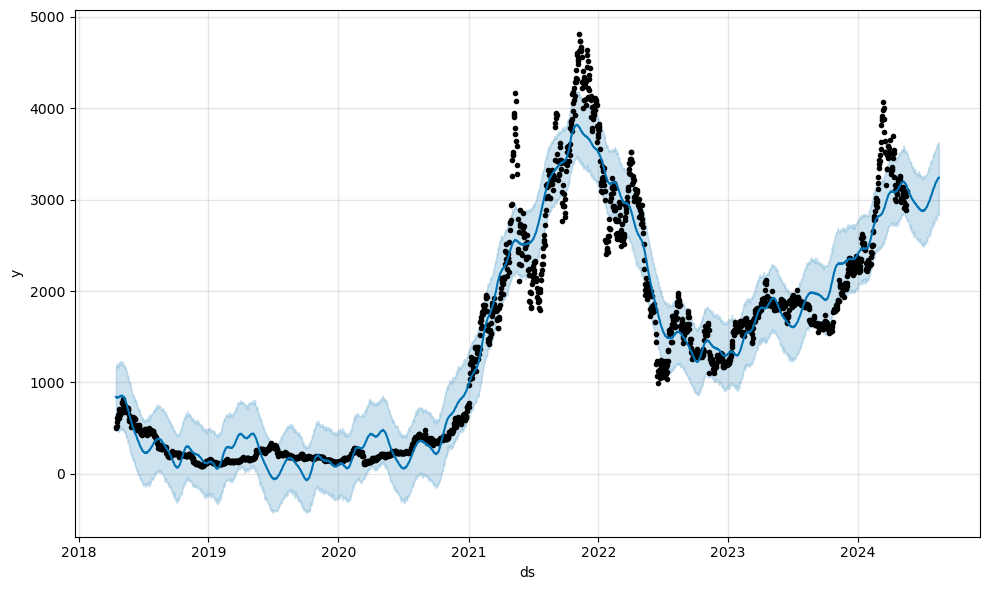

In [20]:
# Plot the Prophet predictions for the data
fig_forecast = crypto_model.plot(crypto_forecast)

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-05-18,3130.700654,2763.734858,3509.125326
2024-05-19,3125.317434,2773.277773,3498.141113
2024-05-20,3115.108446,2775.767475,3484.993337
2024-05-21,3102.565949,2776.579318,3446.610683
2024-05-22,3098.268534,2730.283029,3460.958432
...,...,...,...
2024-08-11,3220.873307,2833.224228,3607.026389
2024-08-12,3226.612975,2865.404177,3595.082433
2024-08-13,3229.498584,2849.411285,3620.016144


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

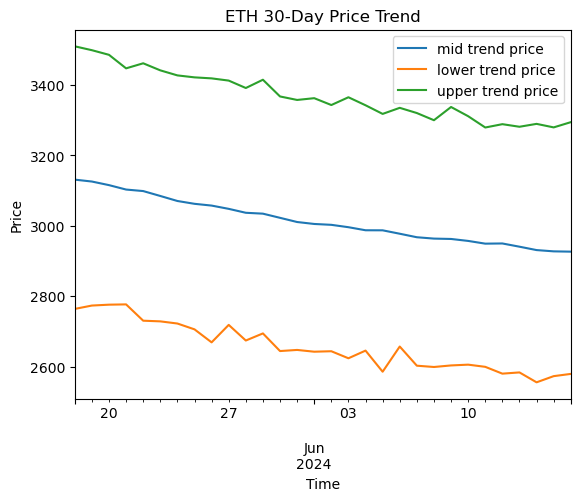

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

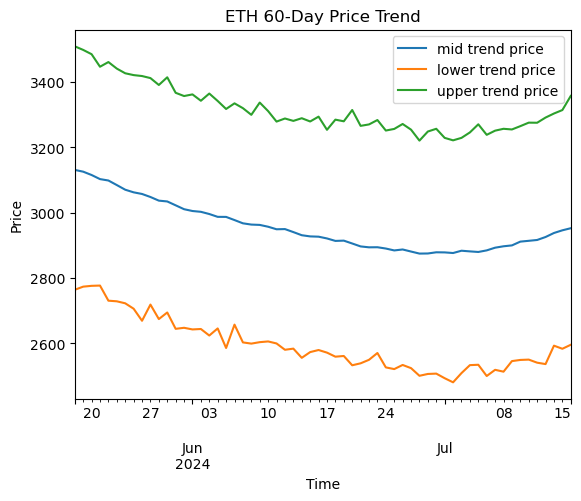

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

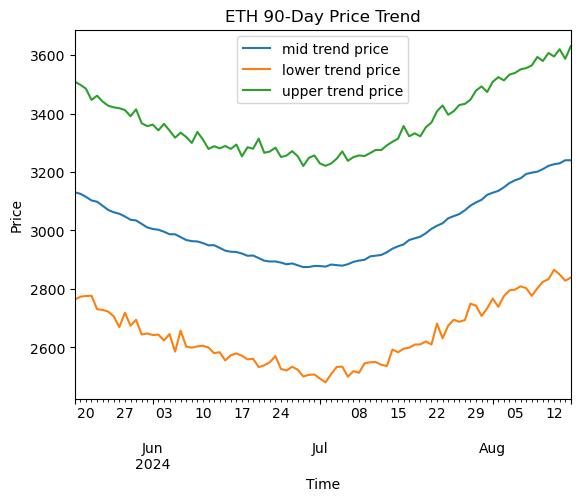

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

3094.12

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

3130.7006541087912

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

3112.4103270543956

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

3132.9924292716646

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

2917.4741822000337

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

2964.545318331234

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

3237.7638328282096

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.063

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

-0.048

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

0.04

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

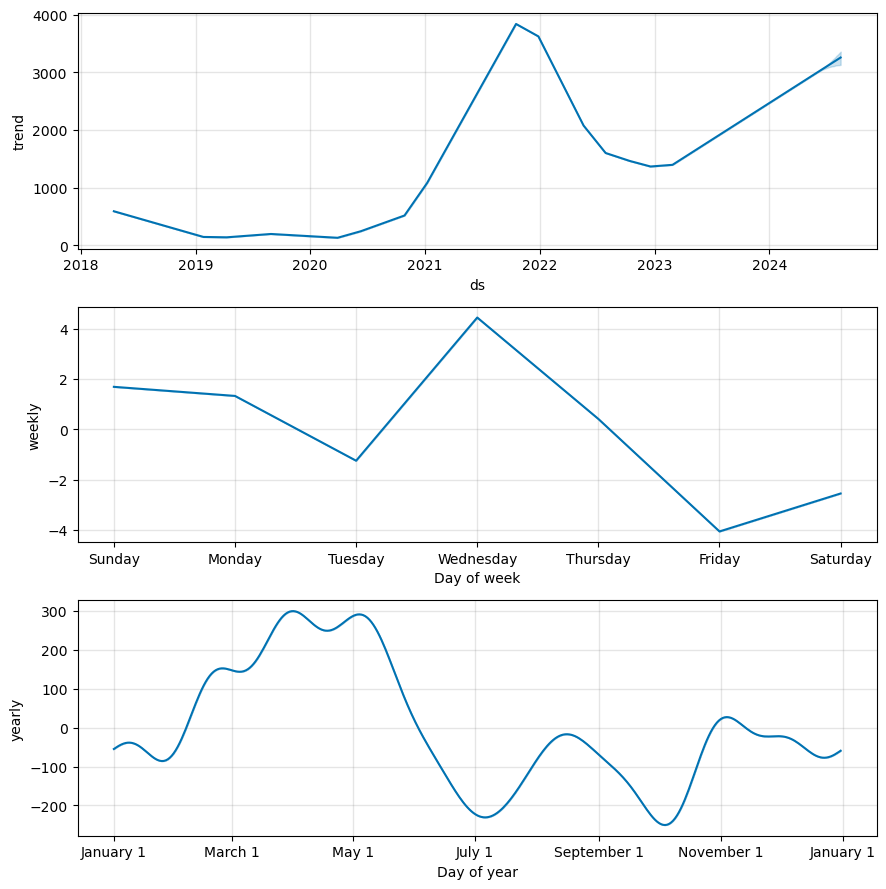

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

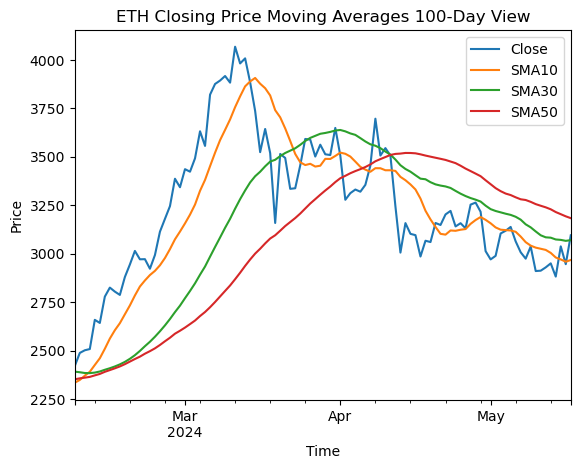

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

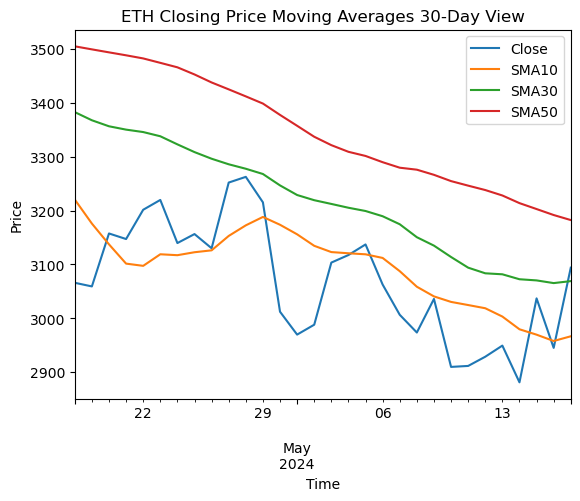

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')   
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-05-20
File created :  2024-05-20.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.467602,0.016141654551261597,-0.048511607018260405,0.26698037580557354
BNB,574.63,-0.3370363083405419,-0.3290568236386213,-0.2790790471601129
BONK,2.5e-05,0.25779530706847753,0.4080859075709553,0.5429258111537147
BTC,66278.37,-0.2191180233361938,-0.1951255528263407,-0.16020045358030566
DOGE,0.149107,-0.22857973922643027,-0.28954294972299366,-0.13383869168157447
ETH,3094.12,-0.05566025624110993,-0.04356552970504457,0.046438254274701274
PEPE,9e-06,0.3163098292378519,0.5695209080409678,0.79019064181281
SHIB,2.4e-05,-0.13447450951251372,-0.07783705937680974,-0.018044767636294923
SOL,170.09,0.02993653747852032,0.09897686371903935,0.15883864333841902
XRP,0.509661,0.08170842018061886,0.1175389631277377,0.251808862234169
ADA,0.467602,-0.05356931769426376,-0.12050457682285454,0.1829944797779357
ADA,0.467602,-0.07589607234414741,-0.135242805763105,0.15993249027663747
BNB,574.63,-0.23839504335644301,-0.2336482812093087,-0.1748296149590688
BONK,2.5e-05,0.1887956631518306,0.32592832450639286,0